# Positional Embeddings

- The way of injecting positional information into the token representations.
- Each token has token embedding and positional embedding.

$$
\LARGE PE(pos,2k) = \sin\left(\frac{pos}{10000^{2k/d}}\right)
$$

$$
\LARGE PE(pos,2k+1) = \cos\left(\frac{pos}{10000^{2k/d}}\right)
$$

- Here d is the embedding dimension - Size of the embedding vector


# Word Embeddings

- Fixed size dense representation of words ( tokens)
- Capturing semantic meaning
- CBOW → Predicting target from context
- SKIPGRAM → Predicting the context from target.
- Glove, FastText, ELMO, BERT  (Examples of embeddings)
- n-grams : Predicting the next word given the context.
- Example : Tri-gram model captures context from two previous words to predict the next word.

$$
\LARGE P(w_i|w_{i-2},w_{i-1}) = \frac{\text{\# three words together}}{\text{\# Count of the given two words}}
$$

# CBOW Model Implementation

In [3]:
import os 
os.getcwd()

'/Users/thomaskuttyreji/Documents/GitHub/Data-Science-Knowledge-Base'

In [4]:
import torch
from torch import nn 
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
torch.manual_seed(101) 

class CBOW(nn.Module):
    # given a context of some words what is the target
    def __init__(self,embedding_size,vocab_size):
        super(CBOW,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_size)
        self.linear = nn.Linear(embedding_size,vocab_size)
        self.logits = nn.Softmax(dim=1)
    def forward(self,x):
        #shape x : (BATCH_DIM,CONTEXT*2) 
        emb_x = self.embedding(x).mean(1) # (B,EMB_DIM)
        output = self.linear(emb_x) #(BATCH_DIM,VOCAB_DIM)
        probs = self.logits(output)
        return probs 

with open('data/fault_in_our_stars.txt') as file:
    text = file.read()
words = [i.replace('.','') for i in text.replace('/n',' ').split() if len(i)>0]
words = [i.lower() for i in words]
unique_words = list(set(words))
index2word = {ind:word for ind,word in enumerate(unique_words)}
word2index = {j:i for i,j in index2word.items()}

training_pairs = []
for i in range(2,len(words)-2):
    context = words[i-2:i]+words[i+1:i+3]
    context = torch.tensor([word2index[i] for i in context])
    target = words[i]
    target = torch.tensor(word2index[target])
    pair = (context,target)
    training_pairs.append(pair)


class dataset(Dataset):
    def __init__(self,training_pairs):
        self.training_pairs = training_pairs
  
    def __getitem__(self,idx):
        return self.training_pairs[idx][0],self.training_pairs[idx][1]
    def __len__(self):
        return len(self.training_pairs)
    
trainset = dataset(training_pairs)
train_loader = DataLoader(trainset,batch_size=16,shuffle=False)


EMB_DIM = 128
N_EPOCHS = 400
LEARNING_RATE = 0.001
EVAL_INTERVAL = 40

loss_func = nn.CrossEntropyLoss()
VOCAB_SIZE = len(index2word) 
cbow_model = CBOW(embedding_size=EMB_DIM,vocab_size=VOCAB_SIZE)
optimizer = optim.Adam(cbow_model.parameters(),lr = LEARNING_RATE)
for epoch in range(N_EPOCHS):
    for context,target in train_loader:
        output = cbow_model(context)
        loss = loss_func(output,target)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
    if epoch % EVAL_INTERVAL == 0 or iter == epoch - 1:
        print(f'Epoch :{epoch}; loss : {loss} ')


@torch.no_grad()
def evaluate(context_words):
    context_indexes = torch.tensor([word2index[i] for i in context_words])
    context_indexes = context_indexes.unsqueeze(0) 
    probs = cbow_model(context_indexes)
    return probs
    
probs  = evaluate(['communicated',"exclusively","sighs","almost"])
argindex = probs.argsort(descending = True)[0]
final_words = [index2word[i.item()] for i in argindex]
print(final_words)

Epoch :0; loss : 4.912976264953613 
Epoch :40; loss : 3.9592113494873047 
Epoch :80; loss : 3.933823347091675 
Epoch :120; loss : 3.9290273189544678 
Epoch :160; loss : 3.9272830486297607 
Epoch :200; loss : 3.92643404006958 
Epoch :240; loss : 3.9260201454162598 
Epoch :280; loss : 3.9257748126983643 
Epoch :320; loss : 3.9256045818328857 
Epoch :360; loss : 3.925490617752075 
['through', 'exclusively', 'i', 'communicated', 'almost', 'he', 'in', 'whole', 'on', 'his', 'ground-up', 'basically', 'time', 'of', 'sighs', 'wednesday', 'that', 'model,', 'kind', 'while', 'made', 'were', 'when', 'augustus', 'shared', 'problem', 'fantastically', 'couch', 'been', 'group,', 'response', 'each', 'and', 'mom', 'had', '(both', 'fact,', 'get', 'weeks,', 'admittedly', 'you', 'occasions', 'affair', "he'd", 'which', 'so', 'seen,', 'be', 'cancer', 'sigh', 'was', 'about', 'best', 'remaining', 'rare', 'marathon', 'improbable', 'group', "i'd", 'some', 'just', 'wore', 'fin', 'shake', 'thick', 'placed', 'mortal

# SkipGram Model Implementation

Epoch: 1000 cost = 1.939864
Epoch: 2000 cost = 2.036497
Epoch: 3000 cost = 1.680842
Epoch: 4000 cost = 1.769943
Epoch: 5000 cost = 0.861637


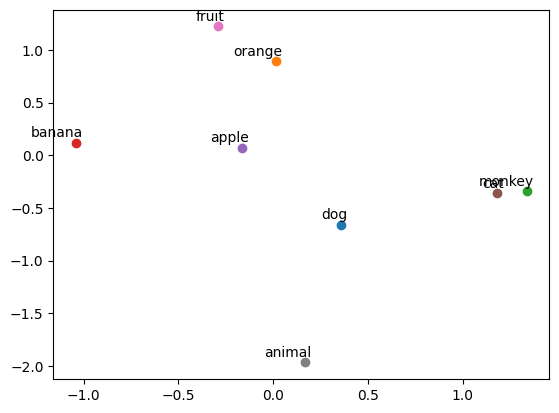

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def random_batch():
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False) # voc_size > embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

if __name__ == '__main__':
    batch_size = 2 # mini-batch size
    embedding_size = 2 # embedding size

    sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
                 "dog cat animal", "cat monkey animal", "monkey dog animal"]

    word_sequence = " ".join(sentences).split()
    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    voc_size = len(word_list)

    # Make skip gram of one size window
    skip_grams = []
    for i in range(1, len(word_sequence) - 1):
        target = word_dict[word_sequence[i]]
        context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
        for w in context:
            skip_grams.append([target, w])

    model = Word2Vec()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    for epoch in range(5000):
        input_batch, target_batch = random_batch()
        input_batch = torch.Tensor(input_batch)
        target_batch = torch.LongTensor(target_batch)

        optimizer.zero_grad()
        output = model(input_batch)

        # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
        loss = criterion(output, target_batch)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    for i, label in enumerate(word_list):
        W, WT = model.parameters()
        x, y = W[0][i].item(), W[1][i].item()
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()


# Markov Model
 - The future depends only on a limited amount of the past.
 - Formally a sequence w_1,w_2,…, w_n satisfies the markov assumption of order k if
    
$$
    \LARGE p(w_{n+1}|w_1,w_2,...,w_n) = p(w_n|w_{n-1},w_{n-2},...,w_{n-k})
$$
    
 - So, instead of using the whole history, you only look at the last k words.
 - Markov Model → Only recent past matters
 - N-gram model → Only recent past words matter, and we estimate it by counting.

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(101)

# --------------------------
# Sample text preprocessing
# --------------------------
with open('data/fault_in_our_stars.txt') as file:
    text = file.read()

words = [i.replace('.', '') for i in text.replace('\n', ' ').split() if len(i) > 0]
words = [i.lower() for i in words]

unique_words = list(set(words))
index2word = {ind: word for ind, word in enumerate(unique_words)}
word2index = {j: i for i, j in index2word.items()}

# --------------------------
# n-gram training pairs
# --------------------------
def create_ngrams(words, n=3):
    """
    Create n-gram training pairs.
    Input: words (list of str), n (int, e.g., 3 for trigram)
    Output: list of (context, target) pairs
    """
    training_pairs = []
    for i in range(n-1, len(words)):
        context = words[i-(n-1):i]   # previous n-1 words
        target = words[i]            # next word
        context_tensor = torch.tensor([word2index[w] for w in context])
        target_tensor = torch.tensor(word2index[target])
        training_pairs.append((context_tensor, target_tensor))
    return training_pairs

N = 3  # Change this to any n for n-gram
training_pairs = create_ngrams(words, n=N)

# --------------------------
# Dataset & DataLoader
# --------------------------
class NGramDataset(Dataset):
    def __init__(self, training_pairs):
        self.training_pairs = training_pairs

    def __getitem__(self, idx):
        return self.training_pairs[idx]

    def __len__(self):
        return len(self.training_pairs)

trainset = NGramDataset(training_pairs)
train_loader = DataLoader(trainset, batch_size=16, shuffle=True)

# --------------------------
# Simple n-gram model
# --------------------------
class NGramLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # sum embeddings of previous words
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, x):
        # x: (batch, context_size)
        emb = self.embedding(x)  # (batch, context_size, embedding_dim)
        emb = emb.view(emb.size(0), -1)  # flatten (batch, context_size*embedding_dim)
        out = torch.relu(self.linear1(emb))
        out = self.linear2(out)
        return out

# --------------------------
# Training loop
# --------------------------
EMB_DIM = 128
VOCAB_SIZE = len(index2word)
model = NGramLM(vocab_size=VOCAB_SIZE, embedding_dim=EMB_DIM, context_size=N-1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

N_EPOCHS = 100

for epoch in range(N_EPOCHS):
    total_loss = 0
    for context, target in train_loader:
        optimizer.zero_grad()
        output = model(context)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

# --------------------------
# Evaluation function
# --------------------------
@torch.no_grad()
def predict_next(context_words):
    context_idx = torch.tensor([word2index[w] for w in context_words]).unsqueeze(0)
    logits = model(context_idx)
    probs = torch.softmax(logits, dim=1)
    top_idx = torch.argmax(probs, dim=1)
    return index2word[top_idx.item()]

# Example
context_example = words[:N-1]
next_word = predict_next(context_example)
print("Context:", context_example)
print("Predicted next word:", next_word)


Epoch 0, Loss: 4.9221
Epoch 10, Loss: 0.3543
Epoch 20, Loss: 0.0746
Epoch 30, Loss: 0.0477
Epoch 40, Loss: 0.0421
Epoch 50, Loss: 0.0443
Epoch 60, Loss: 0.0385
Epoch 70, Loss: 0.0352
Epoch 80, Loss: 0.0343
Epoch 90, Loss: 0.0332
Context: ['and', 'his']
Predicted next word: eyes


# Perplexity

- Measure of how well a probability model predicts a sample.
- **Perplexity is basically the inverse probability of the dataset normalized by length**
- One way to evaluate language models.
- Metric in NLP to capture the degree of uncertainty a model has in predicting text.
- We can assign probabilities to sentences.
- It would be nice to compare the probabilities assigned to different sentences to see which sentences are better predicted by the model.
- longer the sentence the lower will be its probability.
- Normalization can be done by averaging them using the geometric mean.

$$
\LARGE \text{Normalized Probability} = P(W)^{\frac{1}{n}}
$$

Higher this number, the better is the language model. 

Perplexity is the reciprocal of this number. 

Lower perplexity → Better model.

- Perplexity can be computed from the concept of Shannon entropy.
- Following sentences are more or less equivalent;
    - We are maximizing the normalised sentence probabilities given by the language model over well-written sentences.
    - We are minimizing the perplexity of the language model over well-written sentences.
    - We are minimizing the entropy of the language model over well-written sentences.

$$
\begin{align*}
\large \text{Reciprocal of probability:} & \large \quad \text{PP} = P(w_1, \dots, w_N)^{-1/N} \\
\large \text{Product form:} & \large \quad \text{PP} = \left( \prod_{i=1}^{N} \frac{1}{P(w_i \mid history)} \right)^{1/N} \\\large\text{Log form:} & \large \quad \text{PP} = \exp\Big(-\frac{1}{N} \sum_{i=1}^{N} \log P(w_i \mid history)\Big) \\\large \text{Entropy form:} & \large \quad \text{PP} = \exp(H(P,Q))\end{align*}
$$

- Minimum value of perplexity is 1
- For extremely poor prediction , it is infinity ( in theory)
- Lower perplexity is better.

# Binary Log Loss

True Label : $y \in \Set{0,1}$

Predicted probability $\hat{y} = p(y=1|x)$

Then the binary cross-entropy ( log-loss, binary log -loss ) is ; 

$$
\LARGE \text{Log Loss} = -\left( y \log \hat{y} + (1-y) \log (1-\hat{y}) \right)
$$

# Cross Entropy

How many bits on average are needed to encode samples from a true distribution P using a predicted distribution Q. 
$$
\LARGE H(P,Q) = -\sum_x P(x)\log Q(x)
$$
- P(x) is the true probability of the event x
- Q(x) predicted probability of x ( from model)
- If Q matches P perfectly, cross entropy = entropy of P
- If Q is wrong, cross entropy increases → more surprises
- In multi-class classification, cross entropy is the standard loss function.
- Suppose we have C classes.
- True label for sample i is represented as a one-hot vector
    $$
    y_i = [0,0,1,0,0] 
    $$  
- Model predicts probabilities for each class ( using softmax)   
    $$
    \hat{y}_i = [0.1,0.0,0.8,0.0,0.1]
    $$
# KL Divergence

- Kullback - Leibler divergence
- How different one probability distribution Q is from another distribution P
    $$
    \LARGE D_{KL} (P||Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)}
    $$
- P(x) is the true distribution
- Q(x) is the predicted distribution
- Measures the extra surprise or information incurred when you use Q to approximate P

# TF-IDF

- Term Frequency
- Inverse Document Frequency
- It is a numeric statistic that shows how important a word is to a document in a collection ( corpus)
- words that appear frequently in a document are important → TF
- words that appear in many documents are less informative → IDF

So TF-IDF weights words to highlight important terms and reduce common words like the, is, … 

$$
\LARGE TF(t,d) = \frac{\text{\# t appears in document  d}}{\text{\# terms in document d}}
$$

$$
\LARGE IDF(t) = \log \frac{N}{1+DF(t)}
$$

- N is the total number of documents in corpus
- DF(t) is the number of documents containing term t
- Adding 1 in denominator avoids division by zero
- Rare terms → Higher IDF → More weight
- Common Terms → Lower IDF → Less weight

$$
\LARGE TF-IDF(t,d) = TF(t,d) * IDF(t)
$$

- TF-IDF gives a vector representation for terms or documents, but it’s frequency-based, not semantic
- In modern NLP, TF-IDF is sometimes used for lightweight embeddings or feature extraction, but neural embeddings are there for capturing meaning and context

# Self Attention Mechanism

- Focus on relevant parts of the input when producing an output
- Instead of treating all input tokens equally, attention weights them differently depending on their relevance to the current task.
- Before attention, deep learning models process sequences sequentially.
- Long-range dependencies were hard to capture.
- Utilizes 3 weight matrices; $W_q,W_k$ and $W_v$
- Lets say we have input matrix X; ( 3 tokens and embedding dimension 4 )
    $$
    X =\begin{bmatrix}0.5 & 1.2 & -0.3 & 0.8 \\1.0 & -0.5 & 0.7 & 0.2 \\-0.6 & 0.9 & 1.1 & -0.4\end{bmatrix}
    $$
- Each row is an embedding of one token
- Following are the Query, key and value matrix with dimensions 
    $$
    W_Q =\begin{bmatrix}0.2 & 0.1\\0.0 & 0.3\\0.4 & -0.2\\0.1 & 0.5\end{bmatrix},W_K =\begin{bmatrix}0.3 & 0.2\\0.1 & 0.4\\-0.2 & 0.1\\0.5 & -0.3\end{bmatrix}
    $$
    $$
    W_V =\begin{bmatrix}0.1 & 0.0 & 0.2 & 0.5\\0.2 & 0.3 & -0.1 & 0.11\\0.4 & -0.1 & 0.0 & 0.47\\0.0 & 0.5 & 0.3 & 0.21\end{bmatrix}
    $$
- Computing the attention scores using the following ;
$$
\large \text{Attention(Q,K,V)} = \sigma\left(\frac{QK^T}{\sqrt{d_k}} \right)V
$$

In [6]:
import numpy as np
X = np.array([[0.5, 1.2, -0.3, 0.8],
              [1.0, -0.5, 0.7, 0.2],
              [-0.6, 0.9, 1.1, -0.4]])  
W_Q = np.array([[0.2, 0.1],
                [0.0, 0.3],
                [0.4, -0.2],                    
                [0.1, 0.5]])   
W_K = np.array([[0.3, 0.2],
                [0.1, 0.4],
                [-0.2, 0.1],
                [0.5, -0.3]])
W_V = np.array([[0.1, 0.0, 0.2, 0.5],
                [0.2, 0.3, -0.1, 0.11],
                [0.4, -0.1, 0.0, 0.47],
                [0.0, 0.5, 0.3, 0.21]]) 

# create query, key and value matrices
Q = np.dot(X, W_Q)  # shape (3, 2)
K = np.dot(X, W_K)  # shape (3, 2)
V = np.dot(X, W_V)  # shape (3, 4)  

# display it nicely formatted
np.set_printoptions(precision=4, suppress=True)
print("Query matrix Q:\n", Q)
print("Key matrix K:\n", K)
print("Value matrix V:\n", V)

Query matrix Q:
 [[ 0.06  0.87]
 [ 0.5  -0.09]
 [ 0.28 -0.21]]
Key matrix K:
 [[ 0.73  0.31]
 [ 0.21  0.01]
 [-0.51  0.47]]
Value matrix V:
 [[ 0.17   0.79   0.22   0.409]
 [ 0.28  -0.12   0.31   0.816]
 [ 0.56  -0.04  -0.33   0.232]]


In [7]:
d_k = Q.shape[1]  # dimension of the key vectors
scores = np.dot(Q, K.T) / np.sqrt(d_k)  # shape (3, 3)

# apply softmax to each row
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)
        
attention_weights = softmax(scores)  # shape (3, 3)
output = np.dot(attention_weights, V)  # shape (3, 4)

In [8]:
output

array([[0.344 , 0.2274, 0.0443, 0.4599],
       [0.3077, 0.2665, 0.1095, 0.5024],
       [0.3184, 0.2387, 0.0962, 0.5009]])

- Before attention, each word has its own embedding, independent of others.
- After attention, each word’s new vector is a mixture of all words, weighted by relevance.
- A token is no longer just ‘itself’ - it becomes ‘itself plus the context it cares about’
- Attention : Compare what I want (Q) with what everyone is (K), then take information (V) from the most relevant ones.
- Attention Mechanism in general  : Given something I’m trying to produce, which parts of the available information should I focus on?
- Cross Attention
    - Queries come from the decoder
    - Keys K and Values V come from the encoder
    - While generating each output token, look back at the input and decide which input parts matter.

# Cosine Similarity

Cosine similarity measures how similar two vectors are based on the angle between them, not their length. 

$$
\large \frac{a.b}{\||a|| * \||b||}
$$

- +1 if both a and b are in the same direction
- 0 if they are orthogonal
- -1 if they are in opposite direction

# Covariate Shift and Normalization

- Statistical properties of your input data can change between different stages of training or inference. The distribution changes over time ( from one layer to another) 
- Problem : when the input data distribution changes, model parameters might suddenly see examples that look different from what they saw before. This forces readjusting and relearning.  → instability and slower training.
- We can speed up the training of neural network using Normalization methods. Majorly there are 4 types of normalization 
- **Batch Normalization**
    - We compute the mean and standard deviation per each feature across batch.  
- **Layer Normalization**
    - We compute the mean and variance of each sample across features.  
- **Instance Normalization** : Used in images ; Normalize per sample and per channel.
- **Group Normalization** : Here we split channels into groups, then normalize within each group.

# Transformer Architecture
- Sequence to sequence deep learning architecture which relies on attention mechanism. It consist of two parts encoder and decoder.
- Encoder and Decoder built using layers of multi-headed self attention, feed-forward networks, residual connections and layer normalization.
- Encoder reads input sequences and creates contextualised representations.
- Decoder generates output sequence auto regressively, attending to encoder outputs.
- **Input Representation** :
    - Token Embeddings : Each input token is mapped to a dense vector ( word embedding)
    - Positional Embeddings : Since attention is permutation invariant, we add positional information using sinusoidal positional embeddings to the token embeddings.
- **Encoder Layer:**
    - Encoder layer consist of multiple parts which are multi-headed self-attention, feed forward network, residual connections and layer norm.
    - Encoder output is a contextualized token embeddings ( shape is sequence length * model dimension)
- **Multi-Headed Self- Attention**
    - Each token attends to all other tokens in the input sequence, producing a context aware embeddings.
    - Multiple heads allow the model to learn different types of relationships ( syntax, semantics …)
    - Output dimension = $d_{model}$
- **Feed-Forward Network**
    - fully connected layers
    - Usually two layers with a ReLu in between
- **Residual Connections + Layer Norm**
    $$
    \text{Output} = \text{LayerNorm}(x+\text{SubLayer}(x))
    $$
- **Decoder Architecture**
    - Decoder Layer has multiple parts ; masked multi-headed self-attention, cross attention, feed-forward network, residual connections, layer norm.
- **Masked Attention**
    - Each token attends to previous tokens only ( mask future tokens - to avoid cheating in the training phase)
    - Ensures autoregressive generation.
- **Output Layer**
    - Decoder output projected to vocabulary size using linear layer + softmax
    - Each position predicts the next token probability
- **Autogressive Generation**
    - During inference decoder predicts one token at a time.
    - The previously predicted tokens are fed back as input for the next step.

# Byte Pair Encoding

- Subword tokenisation algorithm
- Use the data to tell us how to tokenise
- Three common algorithm
    - Byte pair encoding
    - Unigram language modeling tokenisation
    - Wordpiece
- We start with the set of all individual characters.
- Repeat
    - We first choose the two symbols that are most frequently adjacent in the training corpus. ( eg. a and b)
    - Add the new merged symbol to the vocabulary. (ab)
    - Replace every adjacent a and b in the corpus with ab
- Until k merges have been done.

# Dropout Mechanism

- Dropping a neuron/unit out → Temporarily removing it from the network along with its incoming and outgoing connections.
- The choice of which units to drop is random.
- Each of the nodes was present only p fraction of the times in the training data.
- All these nodes are kinda participating in a discussion ( some of them are sleeping)
- Adding some kind of masking noise
- Prevents neurons from becoming lazy.
- Collectively responsible for final output
- Each neuron should do job in such a way that he is the one who is totally responsible for the loss.

# RNN

- Neural Network for processing/training sequential data.
- The output at time t depends on the current input and the previous hidden state.
$$
    \Large h_t = \tanh(W_xx_t + W_h h_{t-1}+b) 
$$
    
$$
    \Large y_t = W_y h_t + c
$$

In [9]:
import torch
import torch.nn as nn

# Dimensions
batch_size = 2
seq_len = 4
input_size = 3
hidden_size = 5

# Create dummy input
# Shape: (batch, seq_len, input_size)
x = torch.randn(batch_size, seq_len, input_size)

# Define RNN
rnn = nn.RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    batch_first=True
)

# Initial hidden state
# Shape: (num_layers, batch, hidden_size)
h0 = torch.zeros(1, batch_size, hidden_size)

# Forward pass
output, hn = rnn(x, h0)

print("Input x shape:", x.shape)
print("Initial hidden h0 shape:", h0.shape)
print("RNN output shape:", output.shape)
print("Final hidden hn shape:", hn.shape)

Input x shape: torch.Size([2, 4, 3])
Initial hidden h0 shape: torch.Size([1, 2, 5])
RNN output shape: torch.Size([2, 4, 5])
Final hidden hn shape: torch.Size([1, 2, 5])


# LSTM

- During back propagation through time, the gradients shrink/explode exponentially.
- So RNN struggles with long dependencies.
- LSTM fixes this using ;
    - A cell state that flows with minimal change
    - Gates that control information flow
- Instead of overwriting memory every step, LSTM carefully decides what to keep, forget and write.
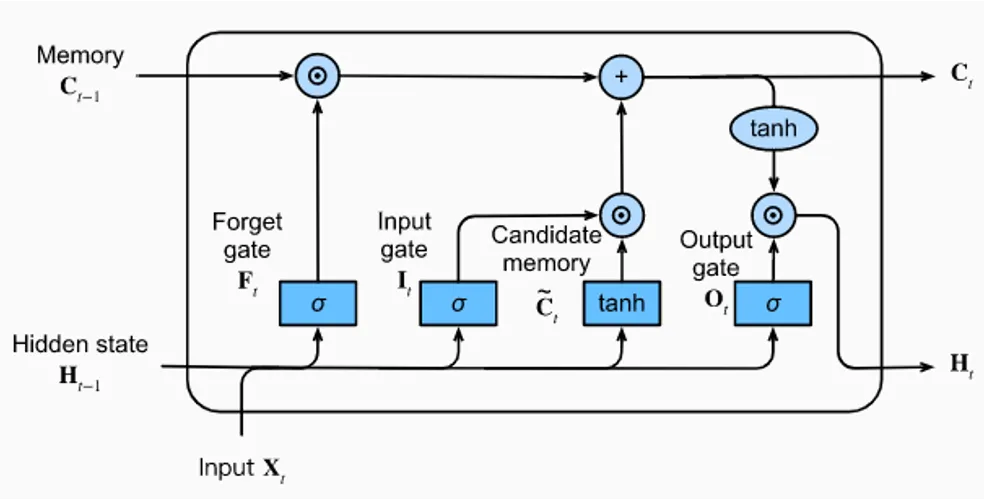
    
$$
    \begin{align*}\text{Forget Gate : } f_t &= \sigma(W_f x_t + U_f h_{t-1} + b_f) \\\text{Input Gate : } i_t &= \sigma(W_i x_t + U_i h_{t-1} + b_i) \\\text{Candidate Memory : } \tilde{c}_t &= \tanh(W_c x_t + U_c h_{t-1} + b_c) \\\text{Cell State : } c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\\text{Output Gate : } o_t &= \sigma(W_o x_t + U_o h_{t-1} + b_o) \\\text{Hidden State : } h_t &= o_t \odot \tanh(c_t)\end{align*}
$$
 

   

# GRU

- Has 2 gates : reset and update
- LSTM has 3 gates : forget, input, output
- Fewer parameters than LSTM
- Faster and simpler
    
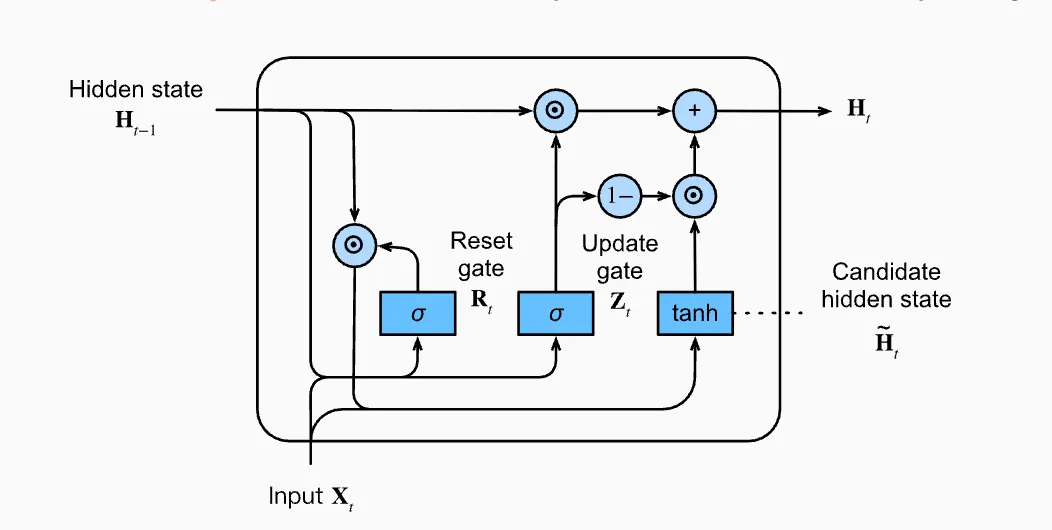
    

$$
\begin{align*} \text{Update Gate : }z_t  &= \sigma(W_z x_t + U_z h_{t-1} + b_z) \\
\text{Reset Gate : }r_t &= \sigma(W_r x_t + U_r h_{t-1} + b_r) \\
\text{candidate hidden state : } \tilde{h}_t &= \tanh\!\left(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h \right) \\
\text{Hidden State : }h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t\end{align*}
$$

# Encoder - Decoder Attention

- Encoding : Read the input sequence token by token, at each step t, compute hidden state and cell state ( if we have lstm cell)
- Context Vector : Take the final hidden state  and cell state as context vector
- Decoder initialization : Initialise the decoder hidden state and cell state
- Autogressive Decoding: For each output step t = 1,2,…, m ; Feed previous token and hidden state and cell state into the decoder, then compute the output and probabilities.
- Output Sequence Generation : Choose the predicted token - then repeat this process until `<EOS>`
    
    

$$
\begin{align*}\text{Encoder: } & (h_t, c_t) = \text{LSTM}(x_t, h_{t-1}, c_{t-1}), \quad t = 1, \dots, n \\& c = h_n, \quad c^{cell} = c_n \\\text{Decoder: } & (s_t, s_t^{cell}) = \text{LSTM}(y_{t-1}, s_{t-1}, s_{t-1}^{cell}) \\& o_t = W_o s_t + b_o \\& P(y_t \mid y_{<t}, X) = \text{softmax}(o_t)\end{align*}
$$

# Encoder - Decoder with Attention

- Instead of having one context, we can have context at each step t ;
- Encoder produces all hidden states h_1,h_2, …, h_n
- Decoder at each step t, looks at all encoder states and decides; which ones matter more right now.
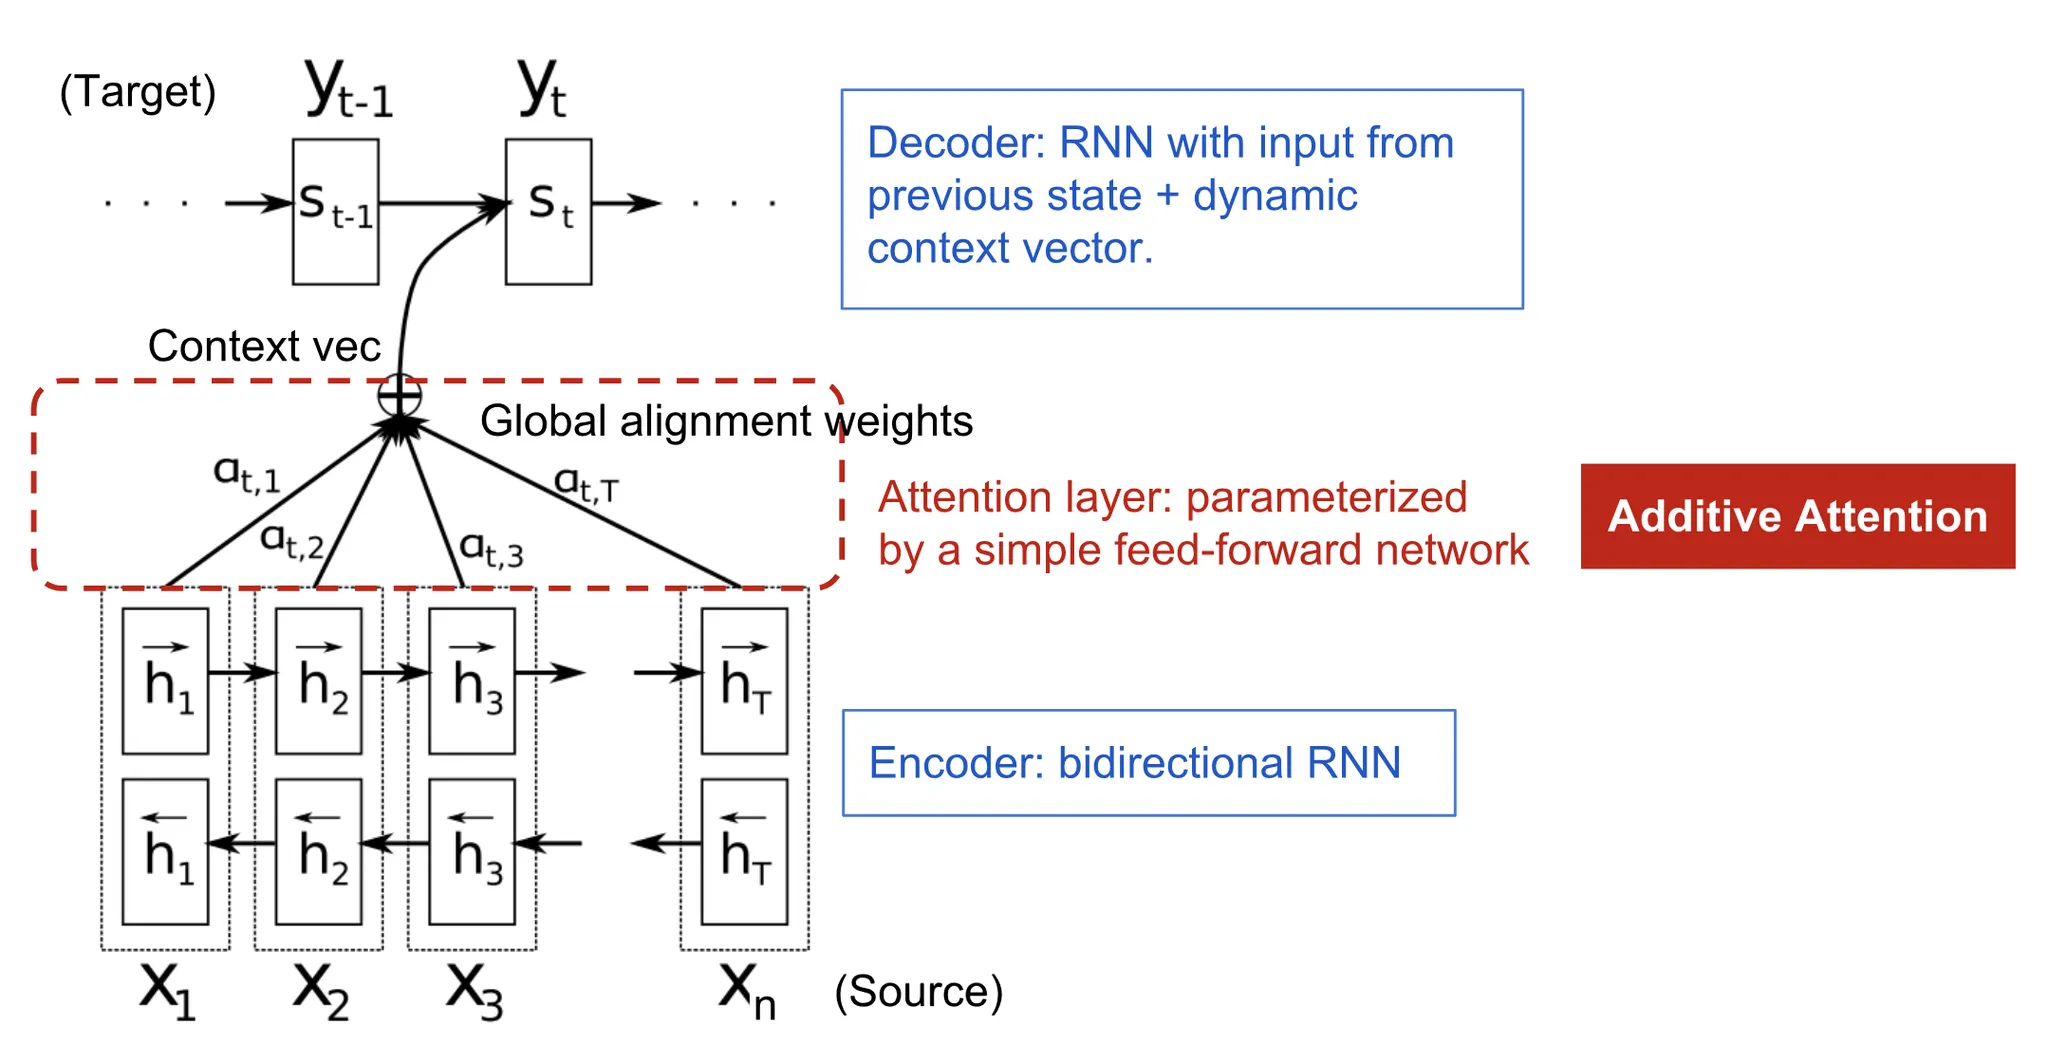
- For each encoder state, we compute an alignment score against the previous decoder hidden state.
- Then we can normalize the score
- Then we can get the weighted sum of h_1, h_2, .. h_n . This is the context window. And this is dynamic , changes at every decoding step.
    

    

# GPT

- Decoder only transformer generate text left to right - next -token prediction
- They use masked - self attention so each token can only attend to past tokens, not future ones.
- Training : Predict the next token using cross entropy loss.
- Inference is autoregressive : start with a prompt, predict one token, append it and repeat.
- Steps:
    - Token + Positional
    - Stack of Identical Decoder Blocks
        - Masked Self-attention
        - Feedforward
        - Residual + Layer Norm
    - Final Linear + softmax

# BERT

- Input : Token + Position + Segment
- Stack of Encoder Blocks
    - Self-attention ( no masking)
    - Feedforward network
    - Residual + LayerNorm
- Objective :
    - Masked Language Modeling : Randomly mask tokens and predict masked tokens using left and right context ( bi-directional)
    - Next Sentence Prediction : Predict if sentence B follows sentence A
- Good at ;
    - Classification
    - NER
    - QA
    - Sentiment Analysis
    - Any task needing deep understanding of text